In [1]:
!pip install monai accelerate evaluate timm -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from tqdm.auto import tqdm
tqdm.pandas()

import monai.transforms as MT
from monai.visualize.utils import matshow3d

from timm import list_models, create_model

from scipy import ndimage as nd

import evaluate
from accelerate import Accelerator, notebook_launcher

%env CUDA_LAUNCH_BLOCKING='1'
torch.autograd.set_detect_anomaly(True)

2024-06-13 15:51:44.590743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 15:51:44.590856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 15:51:44.728347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


env: CUDA_LAUNCH_BLOCKING='1'


In [3]:
def create_df(mode='train'):
    sagittal = Path(f'/kaggle/input/mrnet-v1/MRNet-v1.0/{mode}/sagittal')
    axial = Path(f'/kaggle/input/mrnet-v1/MRNet-v1.0/{mode}/axial')
    coronal = Path(f'/kaggle/input/mrnet-v1/MRNet-v1.0/{mode}/coronal')
    axis = [sagittal, axial, coronal]
    labels = ['acl','meniscus','abnormal']
    base_path = Path('/kaggle/input/mrnet-v1/MRNet-v1.0')
    paths = [base_path/f"{mode}-{l}.csv" for l in labels]
    l1 = pd.read_csv(
        paths[0],
        header=None,
        names=['case', labels[0]], 
        dtype={'case': str, labels[0]: np.int64}
    )
    l2 = pd.read_csv(
        paths[1],
        header=None,
        names=['case', labels[1]], 
        dtype={'case': str, labels[1]: np.int64}
    )
    l3 = pd.read_csv(
        paths[2],
        header=None,
        names=['case', labels[2]], 
        dtype={'case': str, labels[2]: np.int64}
    )
    final_df = pd.DataFrame({
        'case': l1['case'],
        labels[0]: l1[labels[0]],
        labels[1]: l2[labels[1]],
        labels[2]: l3[labels[2]],
    })
    for ax in axis:
        final_df[ax.stem] = final_df['case'].progress_map(lambda p: ax / f"{p}.npy")  
    return final_df

In [4]:
train_df = create_df(mode='train')
valid_df = create_df(mode='valid')

  0%|          | 0/1130 [00:00<?, ?it/s]

  0%|          | 0/1130 [00:00<?, ?it/s]

  0%|          | 0/1130 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

In [5]:
train_df.head()

,case,acl,meniscus,abnormal,sagittal,axial,coronal
0,0000,0,0,1,/kaggle/input/mrnet-v1/MRNet-v1.0/train/sagitt...,/kaggle/input/mrnet-v1/MRNet-v1.0/train/axial/...,/kaggle/input/mrnet-v1/MRNet-v1.0/train/corona...
1,0001,1,1,1,/kaggle/input/mrnet-v1/MRNet-v1.0/train/sagitt...,/kaggle/input/mrnet-v1/MRNet-v1.0/train/axial/...,/kaggle/input/mrnet-v1/MRNet-v1.0/train/corona...
2,0002,0,0,1,/kaggle/input/mrnet-v1/MRNet-v1.0/train/sagitt...,/kaggle/input/mrnet-v1/MRNet-v1.0/train/axial/...,/kaggle/input/mrnet-v1/MRNet-v1.0/train/corona...
3,0003,0,1,1,/kaggle/input/mrnet-v1/MRNet-v1.0/train/sagitt...,/kaggle/input/mrnet-v1/MRNet-v1.0/train/axial/...,/kaggle/input/mrnet-v1/MRNet-v1.0/train/corona...
4,0004,0,0,1,/kaggle/input/mrnet-v1/MRNet-v1.0/train/sagitt...,/kaggle/input/mrnet-v1/MRNet-v1.0/train/axial/...,/kaggle/input/mrnet-v1/MRNet-v1.0/train/corona...


In [6]:
for label in ['acl','meniscus','abnormal']:
    print(label)
    print('train',train_df[label].value_counts().to_dict())
    print('valid',valid_df[label].value_counts().to_dict())

acl
train {0: 922, 1: 208}
valid {0: 66, 1: 54}
meniscus
train {0: 733, 1: 397}
valid {0: 68, 1: 52}
abnormal
train {1: 913, 0: 217}
valid {1: 95, 0: 25}


In [7]:
roi = (224,224,-1)
train_tfms = MT.Compose([
    MT.EnsureChannelFirst(channel_dim='no_channel'),
    MT.Transpose((0,2,3,1)),
    MT.HistogramNormalize(),
    MT.ScaleIntensity(),
    MT.Spacing((1.0,1.0,1.0)),
    MT.RandFlip(0.5,0),
    MT.RandFlip(0.5,1),
    MT.RandRotate(np.pi/8,np.pi/8,np.pi/8,0.3),
    MT.RandRotate90(0.2),
    MT.RandZoom(0.2,0.8,1.2),
    MT.Resize(roi),
    MT.RandScaleIntensity(factors=0.1, prob=0.1),
    MT.RandShiftIntensity(offsets=0.1, prob=0.1),
])
valid_tfms = MT.Compose([
    MT.EnsureChannelFirst(channel_dim='no_channel'),
    MT.Transpose((0,2,3,1)),
    MT.HistogramNormalize(),
    MT.ScaleIntensity(),
    MT.Spacing((1.0,1.0,1.0)),
    MT.Resize(roi),
])

In [8]:
class Dataset:
    def __init__(self, df, tfms, max_len=64, label=None, flat=False):
        self.df = df
        self.max_len = max_len
        self.tfms = tfms
        self.labels = ['acl','meniscus','abnormal']
        self.label = label
        self.axis = ['sagittal','axial','coronal']
        self.wts = torch.tensor([4.4326, 1.8463, 0.2376])
        self.flat = flat
        
    def __len__(self):
        return len(self.df)
    
    def _apply_tfms(self, im):
        im = self.tfms(im)
        im = im.repeat(3,1,1,1) # 3 channel
        return im
    
    def _prep_im_padding(self, p):
        im = np.load(p)
        pad_len = self.max_len - im.shape[0]
        padding = np.zeros((pad_len, *im.shape[1:]),dtype=im.dtype)
        im = np.vstack([padding, im])
        im = self._apply_tfms(im)
        return im
    
    def _prep_im_interpolate(self, p):
        im = np.load(p)
        dsfactor = [w/float(f) for w,f in zip([64,256,256], im.shape)]
        im_resized = nd.zoom(im, zoom=dsfactor)
        im = self._apply_tfms(im)
        return im
    
    def _open_im(self, p):
        im = np.load(p)
        return im
    
    def _2dify(self, im):
        im = im.permute(3,0,1,2) # c, x, y, z -> z, c, x, y
        return im
        
    def __getitem__(self, idx):
        s = self.df.iloc[idx,:]
        sag, ax, cor = s[self.axis].tolist()
        sag, ax, cor = self._open_im(sag), self._open_im(ax), self._open_im(cor)
        sag, ax, cor = self._apply_tfms(sag), self._apply_tfms(ax), self._apply_tfms(cor)
        if self.flat:
            sag, ax, cor = self._2dify(sag), self._2dify(ax), self._2dify(cor)
        labels = torch.tensor([s[self.label]]).float()
        return {
            'sagittal': sag,
            'axial': ax,
            'coronal': cor,
            'labels': labels
        }

In [9]:
label = 'abnormal'
train_ds = Dataset(train_df, train_tfms, label=label, flat=True)
valid_ds = Dataset(valid_df, valid_tfms, label=label, flat=True)

abnormal: 1.0, torch.Size([38, 3, 224, 224])


/opt/conda/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


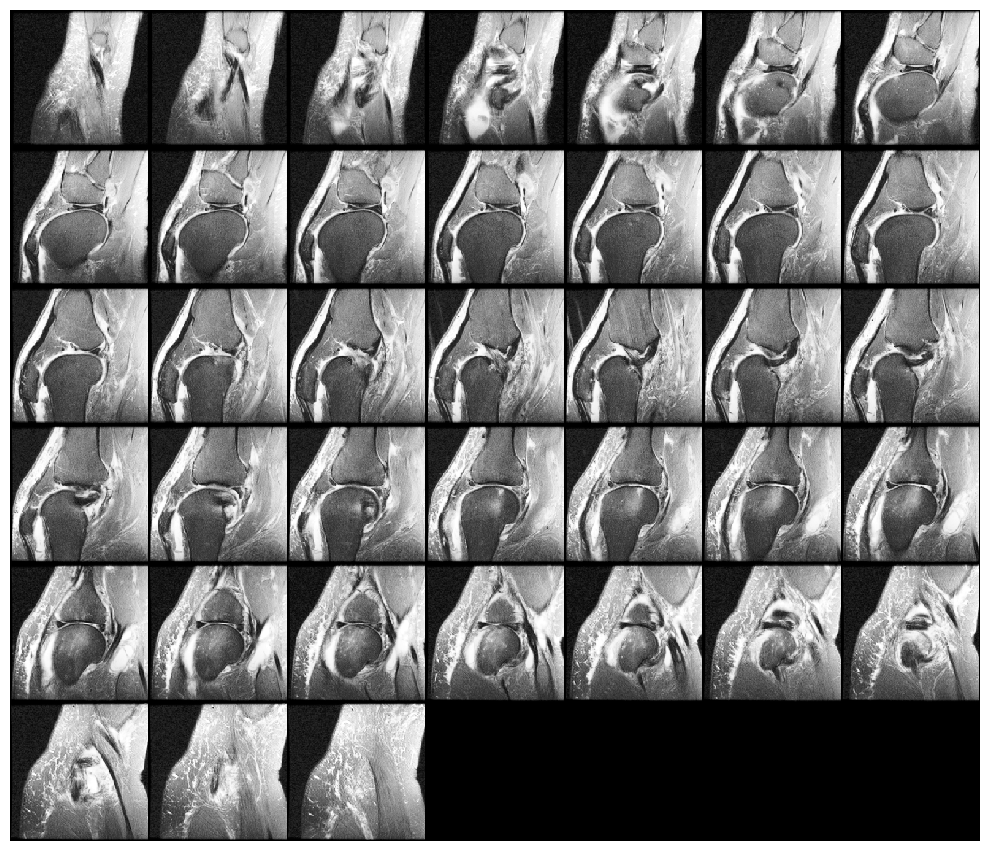

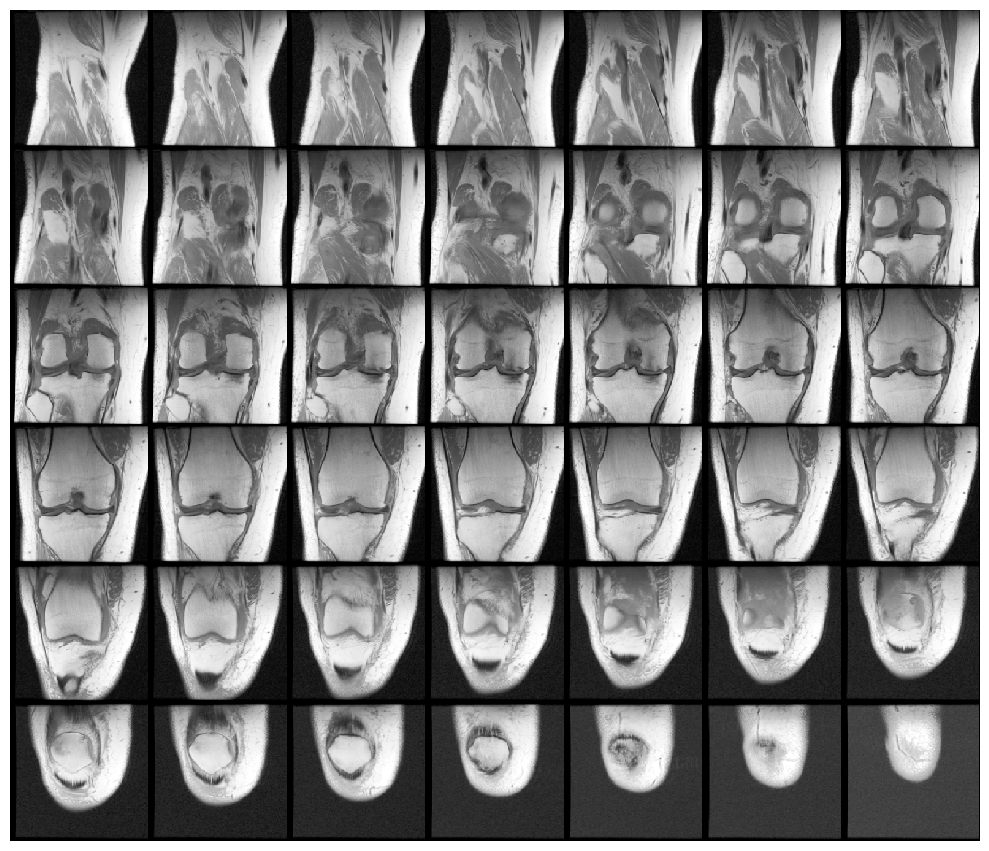

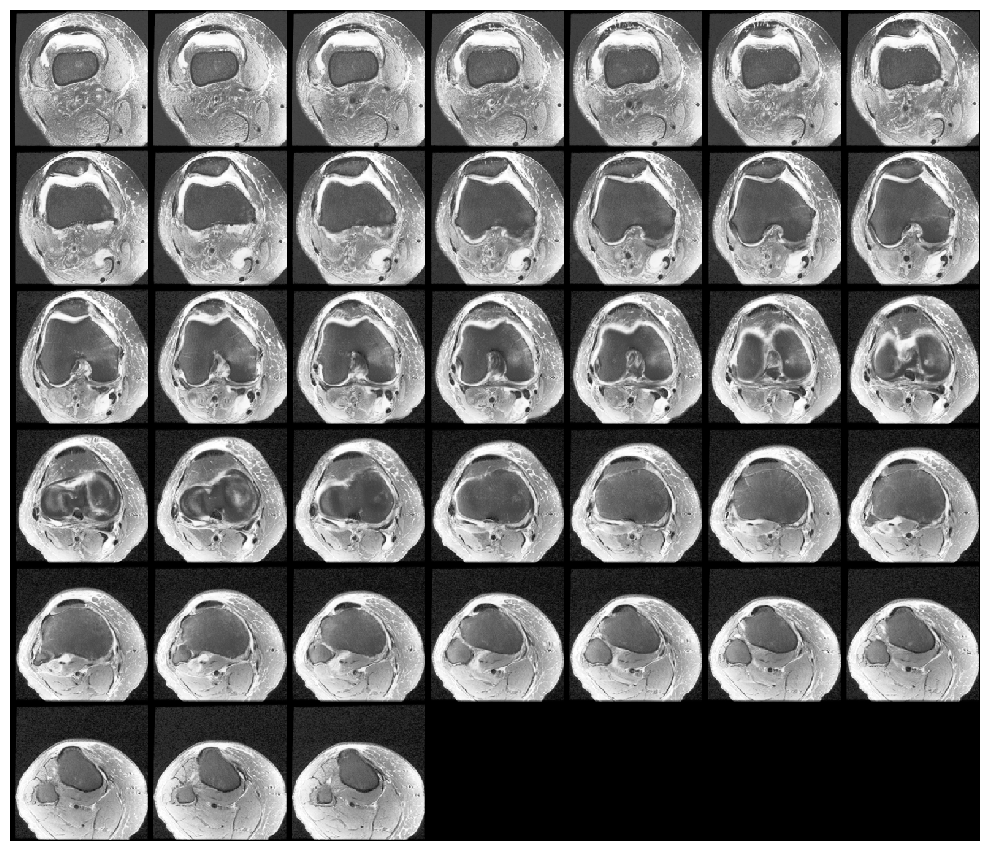

In [10]:
x = train_ds[10]
print(f"abnormal: {x['labels'].item()}, {x['sagittal'].shape}")
matshow3d(x['sagittal'],frame_dim=0,channel_dim=1)
plt.show()
matshow3d(x['coronal'],frame_dim=0,channel_dim=1)
plt.show()
matshow3d(x['axial'],frame_dim=0,channel_dim=1)
plt.show()

In [11]:
# MAX DEPTH: 

# for ax in ['sagittal','axial','coronal']:
#     lens = []
#     for p in tqdm(train_df[ax]):
#         lens.append(np.load(p).shape[0])
#     print(ax, max(lens), min(lens), sum(lens)/len(lens))
# RESULTS:
# sagittal 51 17 30.41592920353982
# axial 61 19 34.316814159292036
# coronal 58 17 29.77787610619469

In [12]:
params = lambda m:sum([p.numel() for p in m.parameters() if p.requires_grad])

In [13]:
class TripleMRNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.sagittal = create_model('resnet10t',pretrained=True,num_classes=0)
        self.axial = create_model('resnet10t',pretrained=True,num_classes=0)
        self.coronal = create_model('resnet10t',pretrained=True,num_classes=0)
        self.head = nn.Linear(512*3, num_classes)
    
    def forward(self, sagittal, axial, coronal):
        sag = torch.squeeze(sagittal,0)
        ax = torch.squeeze(axial,0)
        cor = torch.squeeze(coronal,0)
        
        sag = self.sagittal(sag)
        ax = self.axial(ax)
        cor = self.coronal(cor)
        
        sag = torch.max(sag, 0, keepdim=True)[0]
        ax = torch.max(ax, 0, keepdim=True)[0]
        cor = torch.max(cor, 0, keepdim=True)[0]
        
        logits = torch.cat([sag, ax, cor], 1)
        return self.head(logits)

In [14]:
model = TripleMRNet()
f"{params(model):,}"

model.safetensors:   0%|          | 0.00/21.8M [00:00<?, ?B/s]

'14,769,001'

In [15]:
def train(config):
    
    accelerator = Accelerator()
    
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size = 1,
        shuffle=True,
        num_workers=4,
        drop_last=True
    )

    valid_dl = torch.utils.data.DataLoader(
        valid_ds,
        batch_size = 1,
        shuffle=False,
        num_workers=4,
    )
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    model = TripleMRNet()
    optim = torch.optim.Adam(model.parameters(),lr=config['lr'])
    
    model, optim, train_dl, valid_dl = accelerator.prepare(
        model, optim, train_dl, valid_dl
    )
    
    
    accelerator.print("PRAISE THE LORD! GLORY TO GOD! \n")
    
    best_loss = 1e9
    
    for epoch in range(config['epochs']):
        
        model.train()
        
        train_auroc = evaluate.load('roc_auc')
        running_loss = 0.
        
        for step, batch in enumerate(train_dl):
            
            inputs = {k:v for k,v in batch.items() if k!='labels'}
            labels = batch['labels']
            preds = model(**inputs)
            loss = loss_fn(preds,labels)
            if epoch == 0 and step%50==0:
                accelerator.print(f"batch {step}, loss: {loss.item():.4f}")
            accelerator.backward(loss)
            optim.step()
            optim.zero_grad()
            
            running_loss += loss.item()
            preds, labels = accelerator.gather_for_metrics(
                (preds, labels)
            )
            train_auroc.add_batch(references=labels, prediction_scores=preds.sigmoid())
            
        train_loss = running_loss / len(train_dl)
        train_auroc = train_auroc.compute()['roc_auc']
        
        accelerator.print(f"\n{epoch = }")
        accelerator.print(f"{train_loss = :.3f} | {train_auroc = :.3f}")
        
        model.eval()
        
        running_loss = 0.
        valid_auroc = evaluate.load('roc_auc')
        
        for batch in valid_dl:
            
            inputs = {k:v for k,v in batch.items() if k!='labels'}
            labels = batch['labels']
            with torch.no_grad():
                preds = model(**inputs)
            
            loss = loss_fn(preds, labels)
            running_loss += loss.item()
            
            preds, labels = accelerator.gather_for_metrics(
                (preds, labels)
            )
            valid_auroc.add_batch(references=labels, prediction_scores=preds.sigmoid())
            
            
        valid_loss = running_loss / len(valid_dl)
        valid_auroc = valid_auroc.compute()['roc_auc']
        
        accelerator.print(f"{valid_loss = :.3f} | {valid_auroc = :.3f}")
        
        if valid_loss < best_loss:
            accelerator.print(f'\n\tbest model @ epoch {epoch}\n')
            best_loss = valid_loss
            accelerator.save_model(model, f'./TripleMRNet-Abnormal_BEST')
        
        
        accelerator.save_model(model, f'./TripleMRNet-Abnormal')


In [16]:
config={
    'lr': 3e-4,
    'epochs': 20
}

In [17]:
notebook_launcher(train,(config,),num_processes=1)

Launching training on one GPU.
PRAISE THE LORD! GLORY TO GOD! 



batch 0, loss: 0.4648
batch 50, loss: 0.1348
batch 100, loss: 1.1576
batch 150, loss: 1.0554
batch 200, loss: 0.0954
batch 250, loss: 0.8578
batch 300, loss: 0.0998
batch 350, loss: 0.1706
batch 400, loss: 0.9490
batch 450, loss: 0.1286
batch 500, loss: 0.0163
batch 550, loss: 0.0237
batch 600, loss: 2.2165
batch 650, loss: 2.4865
batch 700, loss: 0.0690
batch 750, loss: 0.0824
batch 800, loss: 0.1397
batch 850, loss: 0.6556
batch 900, loss: 2.3507
batch 950, loss: 0.0991
batch 1000, loss: 0.0218
batch 1050, loss: 1.2087
batch 1100, loss: 0.0170

epoch = 0
train_loss = 0.494 | train_auroc = 0.654
valid_loss = 0.492 | valid_auroc = 0.713

	best model @ epoch 0


epoch = 1
train_loss = 0.453 | train_auroc = 0.707
valid_loss = 0.497 | valid_auroc = 0.712

epoch = 2
train_loss = 0.436 | train_auroc = 0.744
valid_loss = 0.592 | valid_auroc = 0.859

epoch = 3
train_loss = 0.411 | train_auroc = 0.780
valid_loss = 0.511 | valid_auroc = 0.805

epoch = 4
train_loss = 0.402 | train_auroc = 0.794
